마켓켑과 볼륨이 얼마나 상관성이 높을지?

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess

In [8]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [145]:
start_from = '2020-01'
mktcap = data_pp.mktcap_df.loc[start_from:]
vol = data_pp.vol_df.loc[start_from:]
mask = data_pp.mask.loc[start_from:]

coin_id,1,10,100,1000,10005,10006,1001,10011,10016,10023,...,998,9982,9984,9987,9989,999,9991,9996,9997,9998
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.305808e+11,161092.544395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1.266994e+11,161100.135097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1.332334e+11,147193.979495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,1.344425e+11,107343.981053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1.344695e+11,108943.168769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12,5.782690e+11,85961.270000,NaN,NaN,0.0,602391.55,NaN,0.0,0.0,0.0,...,NaN,0.00,61.57,0.00,11783.94,NaN,54421.50,40236.05,39252.87,230641.55
2023-04-13,5.880842e+11,87405.000000,NaN,NaN,0.0,447416.90,NaN,0.0,0.0,0.0,...,NaN,22.87,128.06,661.09,13788.74,NaN,77044.99,70892.62,53148.91,150540.74
2023-04-14,5.897866e+11,175285.630000,NaN,NaN,0.0,446586.56,NaN,0.0,0.0,0.0,...,NaN,42.52,5.67,0.00,24263.74,NaN,101392.88,52233.03,39914.53,64284.05


In [146]:
mktcap_res = mktcap.resample('MS').mean()
vol_res = vol.resample('MS').mean()

m = mktcap_res.melt()
v = vol_res.melt()

concat_df = pd.concat([m,v], axis=1).iloc[:,[0,1,3]].replace(0, np.nan).dropna()
concat_df.columns = ['id', 'mktcap', 'vol']
concat_df

,id,mktcap,vol
0,1,1.523974e+11,2.751201e+10
1,1,1.754658e+11,4.011643e+10
2,1,1.255413e+11,4.162716e+10
3,1,1.324132e+11,3.853757e+10
4,1,1.702298e+11,4.149575e+10
...,...,...,...
419275,9989,3.751646e+05,7.646133e+03
419276,9989,5.837213e+05,1.262168e+04
419277,9989,3.923295e+06,3.913413e+04
419278,9989,2.634614e+06,1.558600e+04


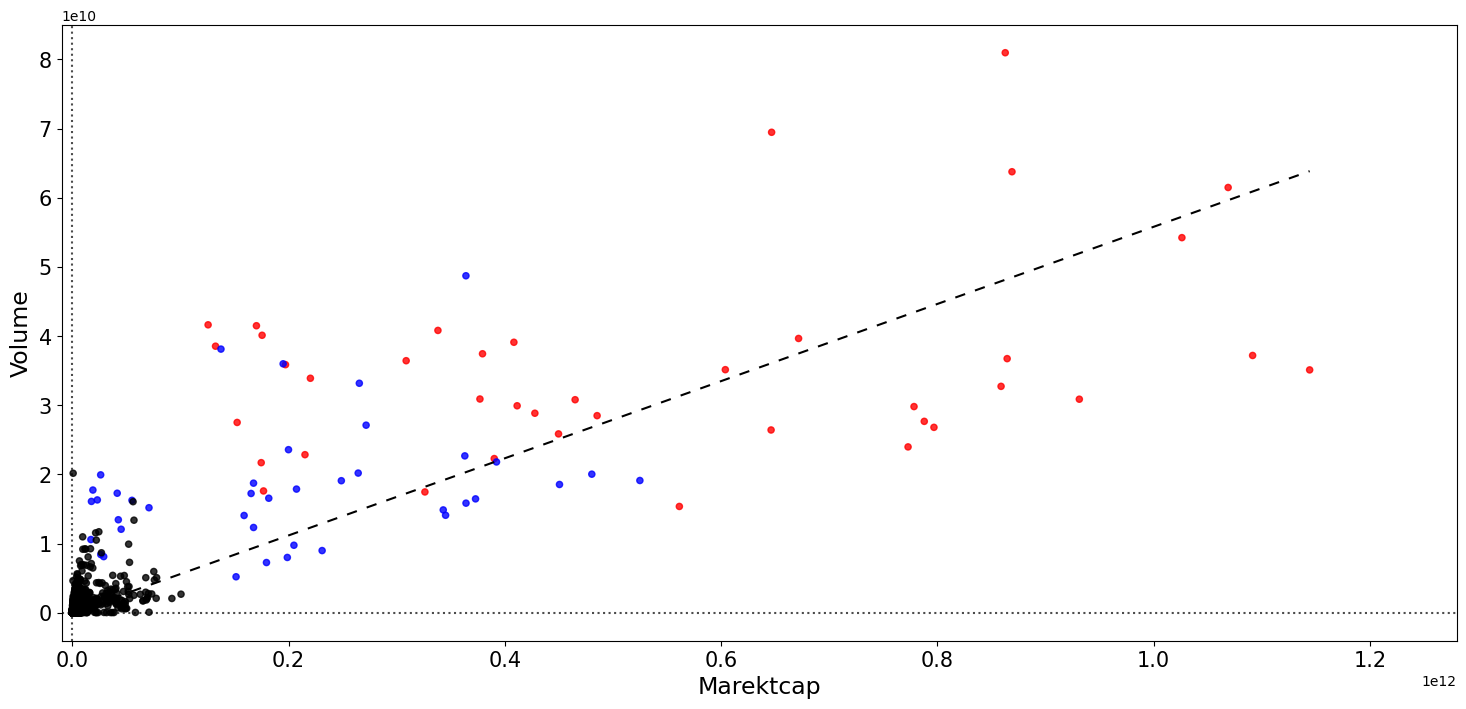

In [147]:
# 빨강은 BTC, 파랑은 이더리움
colors = ['red' if i == '1' else ('blue' if i == '1027' else 'black') for i in concat_df['id']]

concat_df.plot(kind='scatter', 
               x='mktcap',
               y='vol',
               figsize=(18,8),
               fontsize=15,
               alpha=0.8,
               c=colors)

# Fit a linear regression model to the data
m, b = np.polyfit(concat_df['mktcap'], concat_df['vol'], 1)

x = np.linspace(concat_df['mktcap'].min(), concat_df['mktcap'].max(), 100)
y = m * x + b

plt.plot(x, y, c='k', ls='--', dashes=[5, 5])
plt.xlabel('Marektcap', fontsize=17)
plt.ylabel('Volume', fontsize=17)
plt.xlim(-1e10, 1e12+2e11+8e10);
plt.axhline(1_000_000, c='k', ls=':', alpha=0.7)
plt.axvline(1_000_000, c='k', ls=':', alpha=0.7);

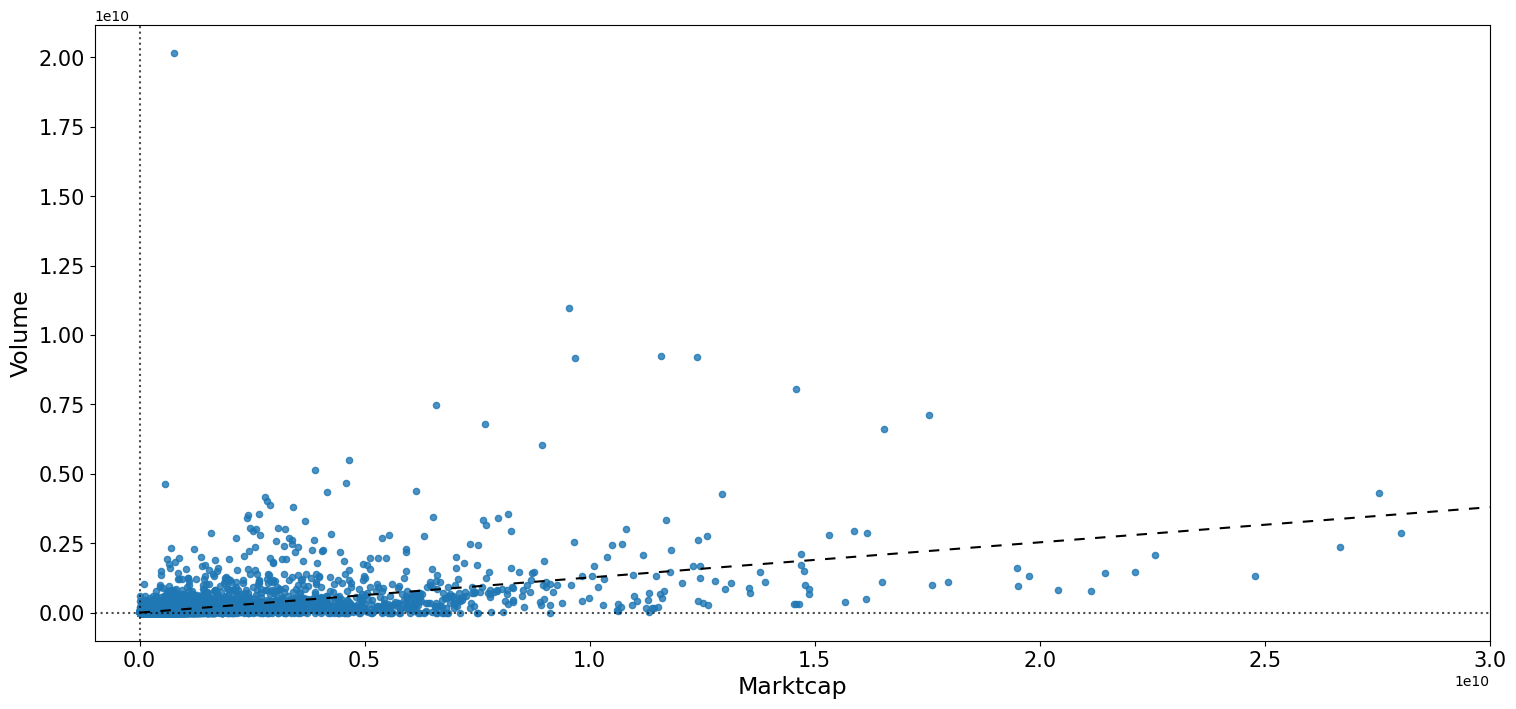

In [148]:
# 비트코인, 이더는 제거
exclude_major = concat_df.loc[~concat_df.id.isin(['1', '1027', '52', '1839', '2010', '74', '5426', '5015', "6636", "1831"])] # 52리플, 1839 BNB,  2010 ADA

#colors = ['red' if i == '1027' else 'blue' for i in exclude_btc['id']]

exclude_major.plot(kind='scatter', 
               x='mktcap',
               y='vol',
               figsize=(18,8),
               fontsize=15,
               alpha=0.8)

# Fit a linear regression model to the data
m, b = np.polyfit(exclude_major['mktcap'], exclude_major['vol'], 1)

x = np.linspace(exclude_major['mktcap'].min(), exclude_major['mktcap'].max(), 100)
y = m * x + b

plt.plot(x, y, c='k', ls='--', dashes=[5, 5])
plt.xlabel('Marktcap', fontsize=17)
plt.ylabel('Volume', fontsize=17)
plt.xlim(-1e9, 3e10);
plt.axhline(1_000_000, c='k', ls=':', alpha=0.7)
plt.axvline(1_000_000, c='k', ls=':', alpha=0.7);

In [154]:
mask1 = exclude_major.vol < 1_000_000
mask2 = exclude_major.mktcap > 1_000_000_00

mask = mask1 * mask2

exclude_major.loc[mask].id.value_counts().iloc[:20]

id
3662    27
3085    23
4361    18
7321    17
5614    17
5482    17
3718    15
4121    14
2499    14
6941    13
3441    13
291     12
3873    12
3748    11
3918    11
2444    11
5514    10
5060    10
3968     9
5072     9
Name: count, dtype: int64

In [169]:
gb = exclude_major.groupby('id')
av_mktcap = gb.mktcap.mean()
av_vol = gb.vol.mean()

(av_mktcap / av_vol).sort_values(ascending=False)

id
502      6.845270e+06
3013     4.421546e+06
1306     3.411675e+06
215      2.488141e+06
1514     1.287371e+06
             ...     
4076     7.256692e-02
7187     4.341636e-02
7161     2.839712e-02
3580     2.390498e-02
12815    1.230941e-02
Length: 2701, dtype: float64

In [155]:
exclude_major.loc[mask]

,id,mktcap,vol
653,1004,1.072571e+08,298301.343929
654,1004,1.437240e+08,337433.314839
655,1004,2.148534e+08,367693.427333
656,1004,2.841803e+08,279560.559677
657,1004,2.892090e+08,211062.137333
...,...,...,...
402929,911,1.136272e+08,25.199793
402931,911,3.038732e+08,632.271018
402932,911,1.262397e+08,2190.314512
417718,9891,1.567617e+08,381962.562581


In [126]:
import statsmodels.api as sm 

ols = sm.OLS(concat_df.vol, sm.add_constant(concat_df.mktcap))
result = ols.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:                  OLS                Adj. R-squared:       0.707       
Dependent Variable:     vol                AIC:                  4730422.8729
Date:                   2023-08-22 20:51   BIC:                  4730442.1000
No. Observations:       110583             Log-Likelihood:       -2.3652e+06 
Df Model:               1                  F-statistic:          2.669e+05   
Df Residuals:           110581             Prob (F-statistic):   0.00        
R-squared:              0.707              Scale:                2.2151e+17  
-----------------------------------------------------------------------------
           Coef.       Std.Err.      t     P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------
const  15188510.7618 1416235.8413  10.7246 0.0000 12412709.1367 17964312.3869
mktcap        0.0565       0.0001 516.6024 0.0000        0.0563        0.0567
-----------------------------------------------------------------------------
Omnibus:             283043.177       Durbin-Watson:          0.371          
Prob(Omnibus):       0.000            Jarque-Bera (JB):       24945094500.645
Skew:                28.346           Prob(JB):               0.000          
Kurtosis:            2329.082         Condition No.:          12950117263    
=============================================================================
* The condition number is large (1e+10). This might indicate
strong multicollinearity or other numerical problems.
"""

In [127]:
import statsmodels.api as sm 

ols = sm.OLS(exclude_major.vol, sm.add_constant(exclude_major.mktcap))
result = ols.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
========================================================================
Model:               OLS               Adj. R-squared:      0.289       
Dependent Variable:  vol               AIC:                 4410617.3203
Date:                2023-08-22 20:51  BIC:                 4410636.5338
No. Observations:    109842            Log-Likelihood:      -2.2053e+06 
Df Model:            1                 F-statistic:         4.464e+04   
Df Residuals:        109840            Prob (F-statistic):  0.00        
R-squared:           0.289             Scale:               1.6079e+16  
------------------------------------------------------------------------
          Coef.       Std.Err.     t     P>|t|     [0.025      0.975]   
------------------------------------------------------------------------
const  1526392.6729 386719.0938   3.9470 0.0001 768428.8246 2284356.5212
mktcap       0.1271      0.0006 211.2853 0.0000      0.1259       0.1283
------------------------------------------------------------------------
Omnibus:           364891.735     Durbin-Watson:        0.852           
Prob(Omnibus):     0.000          Jarque-Bera (JB):     212763084379.979
Skew:              57.983         Prob(JB):             0.000           
Kurtosis:          6820.211       Condition No.:        649840658       
========================================================================
* The condition number is large (6e+08). This might indicate
strong multicollinearity or other numerical problems.
"""

마켓켑이 1M 언저리, 볼륨 낮은 애들 찾아보기

In [110]:
exclude_major.sort_values(by='mktcap').iloc[-10:]

,id,mktcap,vol
1037209,74,3.953255e+10,3.337133e+09
954560,5426,4.065339e+10,2.075493e+09
1002494,6636,4.392667e+10,1.893368e+09
954556,5426,4.458193e+10,5.275132e+09
954557,5426,5.172093e+10,3.066116e+09
954559,5426,5.696386e+10,2.515755e+09
1037208,74,5.699985e+10,1.337943e+10
936189,5015,5.833551e+10,4.185027e+07
954558,5426,6.781931e+10,2.964267e+09
936188,5015,7.092889e+10,7.595978e+07
